# Duc Huy Nguyen - Statistics DRP Project Autumn 2025
## Relationship between Job Postings and Unemployment
### with related Economics metrics

We first import the required libraries for the project

In [1336]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Import some ML models from sklearn
# from sklearn import 

## Loading data and preliminary processing
We then load relevant datasets on job postings, unemployment, interest rates, inflation, stock prices and GDP into our notebook.

In [1337]:
cpi_df = pd.read_csv('Data/monthly_cpi.csv') # Read CPI data
gdp_df = pd.read_csv('Data/quarterly_gdp.csv')# Read GDP data
unemp_df = pd.read_csv('Data/monthly_unemployment_rate.csv') # Read Unemployment data
job_df = pd.read_csv('Data/monthly_job_postings.csv')# Read Job Postings
sp500_df = pd.read_csv('Data/SP500.csv') # Read S&P 500 data
bond_df = pd.read_csv('Data/monthly_bonds.csv') # Read the bonds data
rates_df = pd.read_csv('Data/monthly_federal_funds_rate.csv') # Read the interest rates data

We format the time for our Dataframe 

In [1338]:
for df in [cpi_df, gdp_df, unemp_df, sp500_df, rates_df, bond_df, job_df]: # format dates for data got from FRED
    df.rename(columns={'observation_date' : 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
print(gdp_df.head(10))

                  GDP
date                 
2015-01-01  18063.529
2015-04-01  18279.784
2015-07-01  18401.626
2015-10-01  18435.137
2016-01-01  18525.933
2016-04-01  18711.702
2016-07-01  18892.639
2016-10-01  19089.379
2017-01-01  19280.084
2017-04-01  19438.643


We then format the stock price into monthly data using the last day of the month

In [1339]:
sp500_df = sp500_df.resample('MS').first()
print(sp500_df.head())

              SP500
date               
2015-11-01  2081.24
2015-12-01  2102.63
2016-01-01  2012.66
2016-02-01  1939.38
2016-03-01  1978.35


We then try to estimate the monthly GDP data using resampling and interpolation in Python.  
We are using linear spline to predict the months within a quarter a later months in 2025 without available data

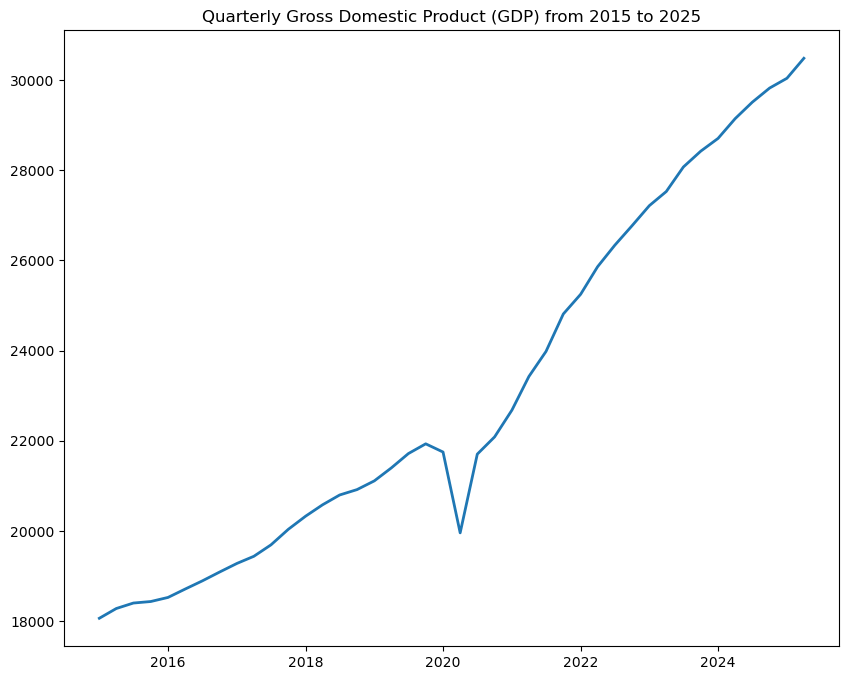

In [1340]:
# First we plot the data before interpolation
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(gdp_df.index, gdp_df['GDP'], linewidth=2, markersize=12)
plt.title('Quarterly Gross Domestic Product (GDP) from 2015 to 2025')
plt.show()

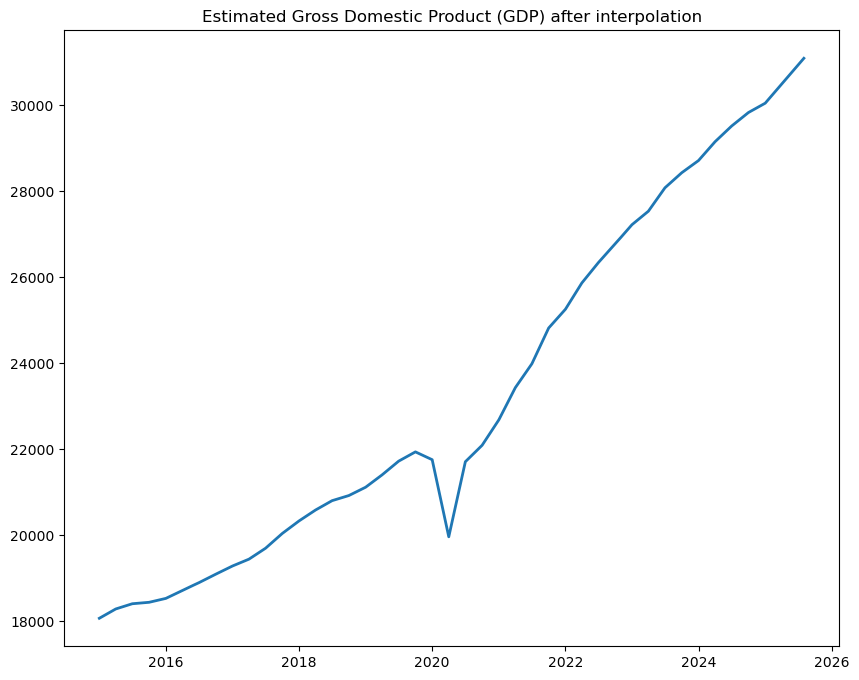

In [1341]:
# We extend our current date time into the future
future_dates = pd.to_datetime(['2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01'])
extended_index = gdp_df.index.union(future_dates)

# print(extended_index)
gdp_df = gdp_df.reindex(extended_index)

# Then we interpolate the data 
gdp_df = gdp_df.resample('MS')
gdp_df = gdp_df.interpolate(method='spline', order = 1)

# Check the data after interpolation
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(gdp_df.index, gdp_df['GDP'], linewidth=2, markersize=12)
plt.title('Estimated Gross Domestic Product (GDP) after interpolation')
plt.show()

## Data Cleaning and Formatting 

In [1342]:
print(cpi_df.head(5))
print(unemp_df.head(5))
print(job_df.head(5))
print(sp500_df.head(5))
print(bond_df.head(5))
print(rates_df.head(5))
print(gdp_df.head(5))

            CPIAUCSL
date                
2015-01-01   234.747
2015-02-01   235.342
2015-03-01   235.976
2015-04-01   236.222
2015-05-01   237.001
            UNRATE
date              
2015-01-01     5.7
2015-02-01     5.5
2015-03-01     5.4
2015-04-01     5.4
2015-05-01     5.6
            JTSJOL
date              
2015-01-01    5344
2015-02-01    5466
2015-03-01    5210
2015-04-01    5598
2015-05-01    5563
              SP500
date               
2015-11-01  2081.24
2015-12-01  2102.63
2016-01-01  2012.66
2016-02-01  1939.38
2016-03-01  1978.35
                  BND
date                 
2014-09-01  59.611656
2014-10-01  60.042507
2014-11-01  60.541515
2014-12-01  60.575878
2015-01-01  62.032001
            FEDFUNDS
date                
2015-01-01      0.11
2015-02-01      0.11
2015-03-01      0.11
2015-04-01      0.12
2015-05-01      0.12
                     GDP
2015-01-01  18063.529000
2015-02-01  18138.028793
2015-03-01  18205.280674
2015-04-01  18279.784000
2015-05-01  18319.901

In [1343]:
# Sanity check on the index type
assert type(cpi_df.index) == type(unemp_df.index) \
       == type(job_df.index)== type(sp500_df.index) \
       == type(gdp_df.index)== type(rates_df.index) \
       == type(bond_df.index)== pd.DatetimeIndex

In [1344]:
# Count the number of Nan values
print(cpi_df.isna().sum())
print(unemp_df.isna().sum())
print(job_df.isna().sum())
print(sp500_df.isna().sum())
print(rates_df.isna().sum())
print(bond_df.isna().sum())
print(gdp_df.isna().sum())

CPIAUCSL    0
dtype: int64
UNRATE    0
dtype: int64
JTSJOL    0
dtype: int64
SP500    0
dtype: int64
FEDFUNDS    0
dtype: int64
BND    0
dtype: int64
GDP    0
dtype: int64


In [1345]:
# Include another Dummy Variables for which Party is winning presidency
dates = pd.date_range(start = "2015-11-01", end = "2025-08-01", freq = "MS")

# Determine the presidency 
def president_party(date):
    if (date < pd.Timestamp("2017-01-20") or 
            pd.Timestamp("2021-01-20") < date < pd.Timestamp("2025-01-20")): # Obama or Biden
        return "Dem"
    else:
        return "Rep"
    
party_df = pd.DataFrame({
    "date": dates,
    "party": [president_party(d) for d in dates]
})

# Dummy variable: 1 = Republican, 0 = Democrat
party_df["party"] = (party_df["party"] == "Rep").astype(int)
party_df.set_index('date', inplace = True)

In [1346]:
# Join those data together
joined_df = cpi_df.join(unemp_df, how='right')
joined_df = joined_df.join(gdp_df, how='left')
joined_df = joined_df.join(job_df, how='left')
joined_df = joined_df.join(rates_df, how='left')
joined_df = joined_df.join(bond_df, how='left')
joined_df = joined_df.join(sp500_df, how='inner')
joined_df = joined_df.join(party_df, how='left')

In [1347]:
# Rename column names for easier use 
joined_df.rename(columns={
    'CPIAUCSL' : 'cpi',
    'UNRATE' : 'unemp',
    'JTSJOL' : 'job_postings',
    'FEDFUNDS' : 'interest_rate',
    'BND' : 'bond'
}, inplace=True)


## ? Maybe we need to standardize all metrics into level compared to base (Optional)


## Exploratory Data Analysis

We then examine our datasets before building our machine learning model 

In [1348]:
joined_df.head(5)

,cpi,unemp,GDP,job_postings,interest_rate,bond,SP500,party
date,,,,,,,,
2015-11-01,238.017,5.1,18465.781555,5708,0.12,61.022045,2081.24,0
2015-12-01,237.761,5.0,18495.393687,5845,0.24,60.914547,2102.63,0
2016-01-01,237.652,4.8,18525.933000,6012,0.34,61.646217,2012.66,0
2016-02-01,237.336,4.9,18589.239811,5770,0.38,62.170757,1939.38,0
2016-03-01,238.080,5.0,18648.406285,6129,0.36,62.719875,1978.35,0


In [1349]:
joined_df.tail(5)

,cpi,unemp,GDP,job_postings,interest_rate,bond,SP500,party
date,,,,,,,,
2025-04-01,320.321,4.2,30485.729000,7395,4.33,71.843536,5633.07,1
2025-05-01,320.580,4.2,30633.383969,7712,4.33,71.359116,5604.14,1
2025-06-01,321.500,4.1,30786.066281,7357,4.33,72.441353,5935.94,1
2025-07-01,322.132,4.2,30933.823358,7208,4.33,72.248886,6198.01,1
2025-08-01,323.364,4.3,31086.505670,7227,4.33,73.082710,6238.01,1


In [1350]:
# Count the number of Nan values
print(joined_df.isna().sum())

cpi              0
unemp            0
GDP              0
job_postings     0
interest_rate    0
bond             0
SP500            0
party            0
dtype: int64


Sources: Job Postings (in thousands) - From the Bureau of Labor Statistics  
Bonds prices taken from Vanguard's BND which focus on wide spectrum of bonds - Yahoo Finance  
Federal Fund Rate (the rate at which banks with each other at the end of night) - Federal Reserve Bank of ST.LOUIS  
CPI, Unemployment rate, S&P 500 - Federal Reserve Bank of ST.LOUIS

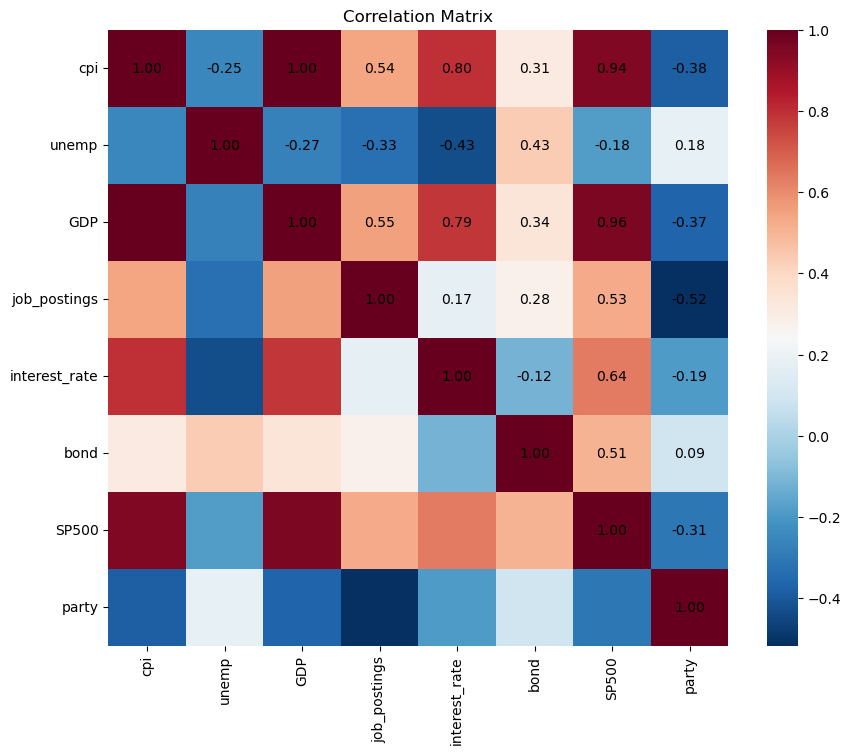

In [1351]:
# Explore the correlation between variables
corr_mat = joined_df.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_mat, cmap='RdBu_r', ax=ax, cbar=True)

for i in range(corr_mat.shape[0]):
    for j in range(i, corr_mat.shape[1]): # upper triangle only
        val = corr_mat.iloc[i, j]
        ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                ha="center", va="center", color="black")

ax.set_title("Correlation Matrix")
plt.show()

Interestingly, GDP and CPI has the correlation of 1.  
We can also see that GDP and S&P500 has high correlation of 0.96 CPI and S&P500 has high correlation of 0.94  
CPI and interest rate also has correlation up to 0.8